<a href="https://colab.research.google.com/github/dvircohen0/Machine-Learning-Algorithms-From-Scratch/blob/main/optical_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://vision.middlebury.edu/flow/data/comp/zip/eval-gray-twoframes.zip
!unzip /content/eval-gray-twoframes.zip

--2021-04-25 17:14:19--  https://vision.middlebury.edu/flow/data/comp/zip/eval-gray-twoframes.zip
Resolving vision.middlebury.edu (vision.middlebury.edu)... 140.233.20.14
Connecting to vision.middlebury.edu (vision.middlebury.edu)|140.233.20.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3139601 (3.0M) [application/zip]
Saving to: ‘eval-gray-twoframes.zip’

eval-gray-twoframes 100%[===================>]   2.99M  2.21MB/s    in 1.4s    

2021-04-25 17:14:22 (2.21 MB/s) - ‘eval-gray-twoframes.zip’ saved [3139601/3139601]

Archive:  /content/eval-gray-twoframes.zip
  inflating: eval-data-gray/Army/frame10.png  
  inflating: eval-data-gray/Army/frame11.png  
  inflating: eval-data-gray/Backyard/frame10.png  
  inflating: eval-data-gray/Backyard/frame11.png  
  inflating: eval-data-gray/Basketball/frame10.png  
  inflating: eval-data-gray/Basketball/frame11.png  
  inflating: eval-data-gray/Dumptruck/frame10.png  
  inflating: eval-data-gray/Dumptruck/frame11.p

In [ ]:
!pip install pyimof
import pyimof
from PIL import Image
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as si
from PIL import Image
import numpy.linalg as lin

     |████████████████████████████████| 3.6MB 5.6MB/s 
     |████████████████████████████████| 3.3MB 38.7MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1


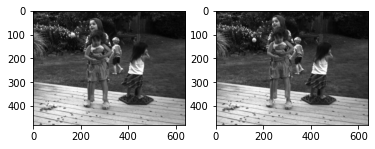

In [ ]:
root_folder = "/content/eval-data-gray"
images_class=random.choice(os.listdir(root_folder ))
images_path=os.listdir(os.path.join(root_folder,images_class))
img1 = Image.open(os.path.join(root_folder,images_class,images_path[0]))
img2 = Image.open(os.path.join(root_folder,images_class,images_path[1]))

# view original images
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(img2, cmap = 'gray')


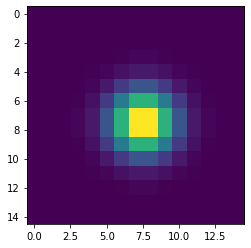

In [ ]:
def gauss_kern(h=15,sigma=1.5):
   x, y = np.mgrid[0:h, 0:h]
   x = x-h/2
   y = y-h/2
   g = np.exp( -( x**2 + y**2 ) / (2*sigma**2) );
   return g / g.sum()

g=gauss_kern(h=15,sigma=1.5)
plt.imshow(g)

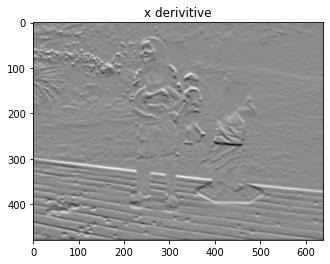

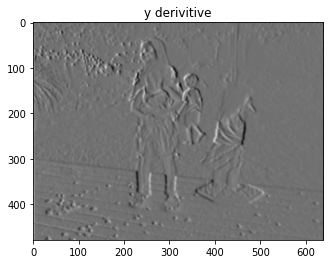

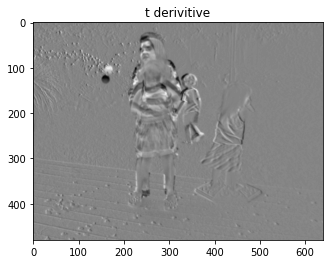

In [ ]:
def deriv(im1, im2):
   g = gauss_kern()
   Img_smooth = si.convolve(im1,g,mode='same')
   fx,fy=np.gradient(Img_smooth)  
   ft = si.convolve2d(im1, 0.25 * np.ones((2,2))) + \
       si.convolve2d(im2, -0.25 * np.ones((2,2)))
                 
   fx = fx[0:fx.shape[0]-1, 0:fx.shape[1]-1]  
   fy = fy[0:fy.shape[0]-1, 0:fy.shape[1]-1];
   ft = ft[0:ft.shape[0]-1, 0:ft.shape[1]-1];
   return fx, fy, ft

img1=np.asarray(img1)
img2=np.asarray(img2)

fx, fy, ft = deriv(img1, img2)

# view derivitevs of images
plt.figure()
plt.title('x derivitive')
plt.imshow(fx, cmap = 'gray')
plt.figure()
plt.title('y derivitive')
plt.imshow(fy, cmap = 'gray')
plt.figure()
plt.title('t derivitive')
plt.imshow(ft, cmap = 'gray')

In [ ]:
def lk(im1, im2, window_size) :
    u = np.zeros(im1.shape)
    v = np.zeros(im2.shape)
    fx, fy, ft = deriv(im1, im2)
    halfWindow = int(np.floor(window_size/2))
    for i in range(int(halfWindow+1),int(fx.shape[0]-halfWindow)):
        for j in range(int(halfWindow+1),int(fx.shape[1]-halfWindow)):
            curFx = fx[i-halfWindow-1:i+halfWindow, 
                       j-halfWindow-1:j+halfWindow]
            curFy = fy[i-halfWindow-1:i+halfWindow, 
                       j-halfWindow-1:j+halfWindow]
            curFt = ft[i-halfWindow-1:i+halfWindow, 
                       j-halfWindow-1:j+halfWindow]
        
            curFx = curFx.flatten() 
            curFy = curFy.flatten() 
            curFt = -curFt.flatten() 
            
            A = np.vstack((curFx, curFy)).T
            U = np.dot(np.dot(lin.pinv(np.dot(A.T,A)),A.T),curFt)
            u[i,j] = U[0]
            v[i,j] = U[1]
    return u,v
u, v = lk(img1, img2, 50)

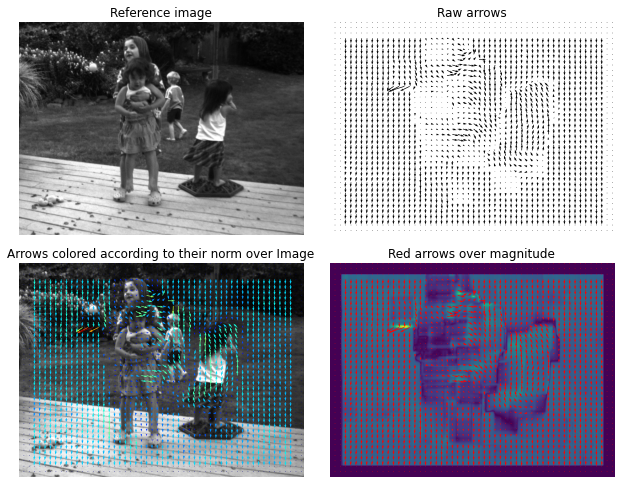

In [ ]:

norm = np.sqrt(u*u + v*v)
fig = plt.figure(figsize=((9, 7)))
ax0, ax1, ax2, ax3 = fig.subplots(2, 2, True, True).ravel()
fig.tight_layout()

ax0.imshow(img1, cmap='gray')
ax0.set_axis_off()
ax0.set_title("Reference image")

pyimof.display.quiver(u, v, ax=ax1)
ax1.set_title("Raw arrows")

pyimof.display.quiver(u, v, c=norm, bg=img1, ax=ax2,
                      cmap='jet', bg_cmap='gray')
ax2.set_title("Arrows colored according to their norm over Image")

pyimof.display.quiver(u, v, bg=norm, ax=ax3, color='r')
ax3.set_title("Red arrows over magnitude")

plt.show()